<a href="https://colab.research.google.com/github/vimesh630/Spice_Price_Predction_VERGER/blob/Cinnamon/LightBGM_for_Forecastig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Mount Google Drive and Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


#2. Load & Prepare Data

In [2]:
file_path = "/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/Cinnamon_Dataset_Preprocessed.csv"
df = pd.read_csv(file_path)

# Convert Month to datetime
df['Month'] = pd.to_datetime(df['Month'])

# Ensure categorical types
df['Grade'] = df['Grade'].astype('category')
df['Region'] = df['Region'].astype('category')

# Target & features
target = 'Regional_Price'
categorical_features = ['Grade', 'Region']
features = [col for col in df.columns if col not in [target, 'Month']]

df = df.sort_values('Month').reset_index(drop=True)

#3. TimeSeriesSplit for Validation

In [3]:
tscv = TimeSeriesSplit(n_splits=5)

fold = 1
metrics = []

for train_idx, val_idx in tscv.split(df):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    X_train, y_train = train_df[features], train_df[target]
    X_val, y_val = val_df[features], val_df[target]

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, val_data],
        num_boost_round=1000,
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(100)]
    )

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

    metrics.append([fold, rmse, mae, r2, mape])

    print(f"\nFold {fold} Results:")
    print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")

    fold += 1

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 44.9703	valid_1's rmse: 120.972
[200]	training's rmse: 34.3904	valid_1's rmse: 118.172
Early stopping, best iteration is:
[167]	training's rmse: 37.7637	valid_1's rmse: 117.703

Fold 1 Results:
RMSE: 117.70 | MAE: 79.60 | R²: 0.9187 | MAPE: 3.00%
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 39.8827	valid_1's rmse: 833.674
[200]	training's rmse: 28.7175	valid_1's rmse: 816.042
[300]	training's rmse: 22.0221	valid_1's rmse: 805.25
[400]	training's rmse: 17.8199	valid_1's rmse: 798.381
Early stopping, best iteration is:
[415]	training's rmse: 17.1081	valid_1's rmse: 797.846

Fold 2 Results:
RMSE: 797.85 | MAE: 586.32 | R²: -0.0028 | MAPE: 13.97%
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's rmse: 142.841	valid_1's rmse: 261.353

Fold 3 Results:
RMSE: 261.35 | MAE: 179.36 | R²: 0.9160 | MAPE: 5.74%
Train

#4. Show Average Metrices

In [4]:
metrics_df = pd.DataFrame(metrics, columns=['Fold', 'RMSE', 'MAE', 'R²', 'MAPE'])
print("\nAverage Across Folds:")
print(metrics_df.mean())


Average Across Folds:
Fold      3.000000
RMSE    287.224409
MAE     207.600810
R²        0.747465
MAPE      5.740128
dtype: float64


#5. Train & Save Final Model

In [5]:
X_train_all, y_train_all = df[features], df[target]
train_all_data = lgb.Dataset(X_train_all, label=y_train_all, categorical_feature=categorical_features)

final_model = lgb.train(
    params,
    train_all_data,
    num_boost_round=int(metrics_df['Fold'].mean()),  # Use avg best rounds
)

final_model.save_model("/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/lightgbm_model_final.txt")

#6. MAPE

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---- 1. Model Evaluation with MAPE ----
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # in %

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

NameError: name 'X_test' is not defined

#7. Feature Importance


Top 10 Important Features:
                Feature    Importance
18          price_lag_1  6.600358e+09
3        National_Price  3.380150e+09
19          price_lag_2  6.370245e+07
20          price_lag_3  5.595104e+07
12       Inflation_Rate  2.994412e+07
6   Local_Export_Volume  1.619154e+07
21          price_lag_6  1.365783e+07
11        Exchange_Rate  1.336171e+07
25     price_roll_std_6  1.268687e+07
1                Region  1.193544e+07


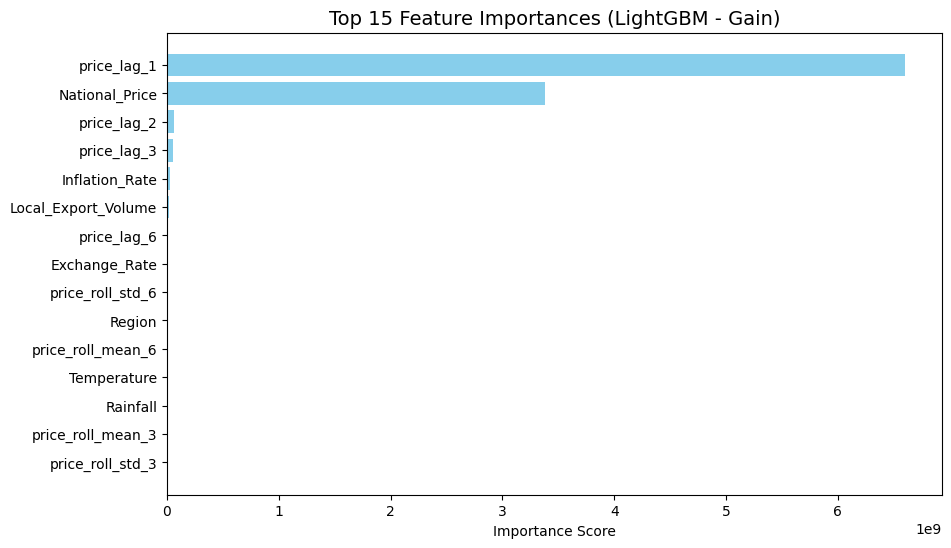

In [ ]:
importance = model.feature_importance(importance_type='gain')
feature_names = X_train.columns

# Create dataframe for sorting & visualization
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features:")
print(fi_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'][:15], fi_df['Importance'][:15], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (LightGBM - Gain)", fontsize=14)
plt.xlabel("Importance Score")
plt.show()

#8. Actual vs Predicted

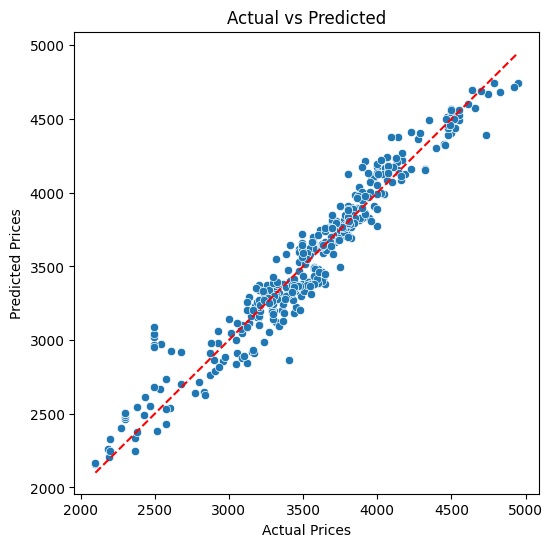

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=model.predict(X_test))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted')
plt.show()

#9. Residuals Distribution

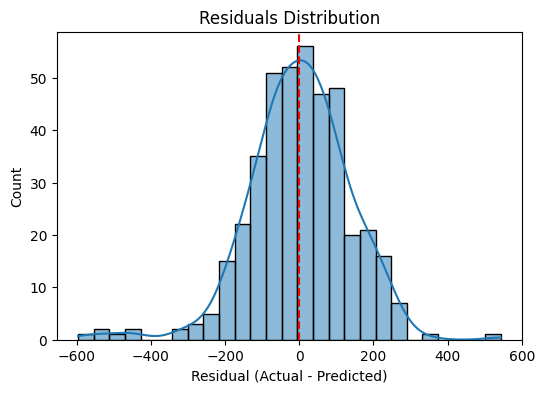

In [ ]:
residuals = y_test - model.predict(X_test)
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Residuals Distribution')
plt.show()

#10. Residuals vs Predicted

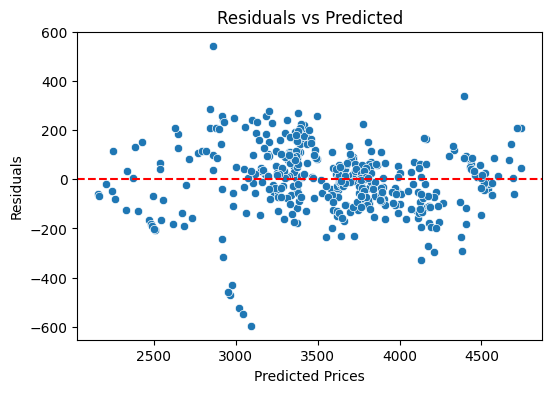

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=model.predict(X_test), y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

#11. Time Series: Actual vs Predicted

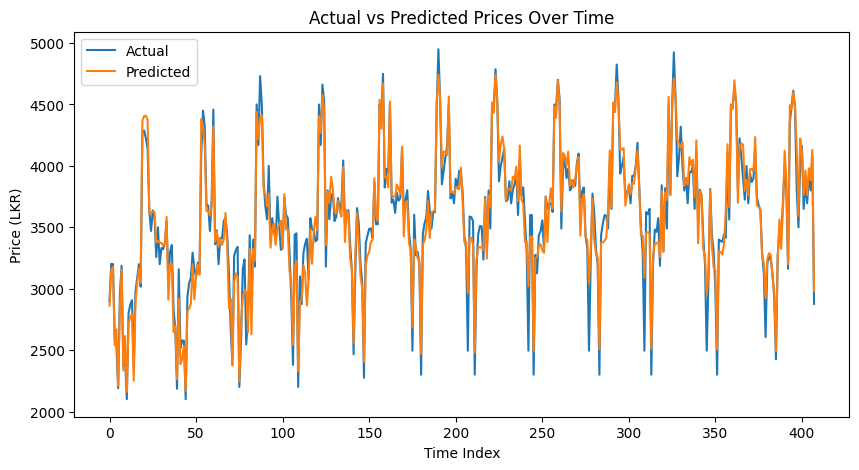

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_test)), model.predict(X_test), label='Predicted')
plt.xlabel('Time Index')
plt.ylabel('Price (LKR)')
plt.title('Actual vs Predicted Prices Over Time')
plt.legend()
plt.show()

#12. Error Over Time

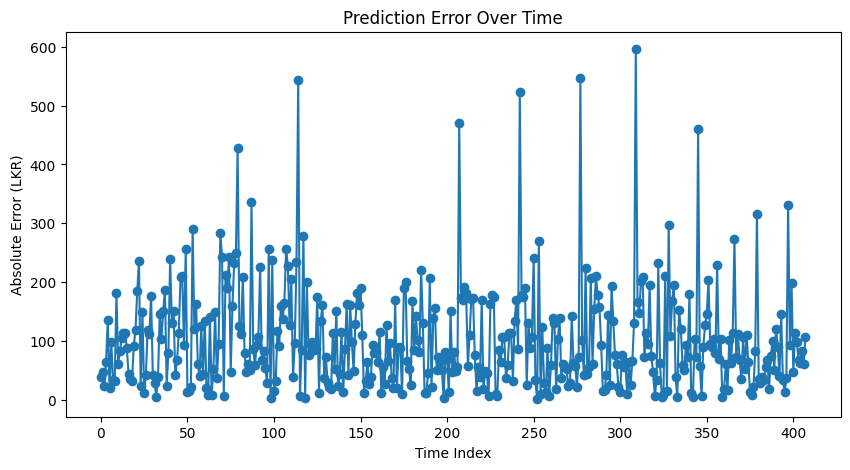

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(len(residuals)), np.abs(residuals), marker='o')
plt.xlabel('Time Index')
plt.ylabel('Absolute Error (LKR)')
plt.title('Prediction Error Over Time')
plt.show()

#13. Save Model

In [ ]:
model.save_model("/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/lightgbm_model.txt")